# Offline 2: Logistic Regression with Bagging and Stacking

### Imports

In [324]:
import pandas as pd
import numpy as np
#from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#pred flag
pred_flag = 0 #no pred columns in dataset
l_rate = 0.1
itr = 1000 
reg = 'l1'
lambda_val = 0.1

### Logistic Regression Implementation

In [325]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, iterations=1000, regularization=None, lambda_=0.01):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.bias = None
        self.weight = None
        self.threshold = 0.5
        self.regularization = regularization
        self.lambda_ = lambda_

    def Sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    # def LogLoss(self, y_pred, y_train):
    #     #return -np.mean(y_train * np.log(y_pred) + (1 - y_train) * np.log(1 - y_pred))
    #     sum = 0
    #     for i in range(len(y_train)):
    #         v1 = y_train[i]
    #         v2 = y_pred[i]
    #         sum += (v1 * np.log(v2)) + ((1 - v1) * np.log(1 - v2))  
        
    #     loss = -sum/len(y_train)
    #     return loss
    
    def fit(self, X_train, y_train):
        rows = X_train.shape[0]
        cols = X_train.shape[1]

        self.bias = 0
        self.weight = np.zeros(cols)

        for i in range(self.iterations):
            # z = W.X + b
            z = np.dot(X_train, self.weight) + self.bias
            y_pred = self.Sigmoid(z)

            # calculate the gradient
            dw = np.dot(X_train.T, (y_pred - y_train))
            dw /= rows

            if self.regularization == 'l1':
                dw += self.lambda_ * np.sign(self.weight) * (1 / rows)
            elif self.regularization == 'l2':
                dw += 2 * self.lambda_ * self.weight * (1 / rows)
                

            db = np.sum(y_pred - y_train)
            db /= rows

            self.weight -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X_test):
        z = np.dot(X_test, self.weight) + self.bias
        y_pred = self.Sigmoid(z)
        for i in range(len(y_pred)):
            if y_pred[i] > self.threshold:
                y_pred[i] = 1
            else:
                y_pred[i] = 0
        return y_pred


### Scaling Function 

In [326]:
def dataScaler(sl, dataframe):
    dataframe_scaled = dataframe.copy()
    if sl == 1:
        for col in dataframe.columns:
            if dataframe[col].dtype == 'int64':
                scaler = StandardScaler()
                dataframe_scaled[col] = scaler.fit_transform(dataframe[[col]])
    elif sl == 2:
        for col in dataframe.columns:
            if dataframe[col].dtype == 'int64':
                scaler = MinMaxScaler()
                dataframe_scaled[col] = scaler.fit_transform(dataframe[[col]])

    return dataframe_scaled

### Preprocessing Dataset1: Telco Customer Churn

In [327]:
def DS1():
    dataframe = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

    pd.set_option('display.max_columns', None)

    print("Number of missing values IN DS1:")
    dataframe.isnull().sum()

    print("Number of duplicated rows IN DS1:")
    print(dataframe.duplicated().sum())

    print("data types:")
    print(dataframe.dtypes)

    print("Number of unique values in TotalCharges column:")
    print(dataframe['TotalCharges'].value_counts())

    dataframe['TotalCharges'] = dataframe['TotalCharges'].replace(' ', None)

    print("Number of unique values in TotalCharges column after replacement:")
    print(dataframe['TotalCharges'].value_counts())

    print("Number of missing values IN DS1 after replacement:")
    dataframe.isnull().sum()

    dataframe['TotalCharges'] = dataframe['TotalCharges'].astype(float)
    dataframe.fillna(dataframe['TotalCharges'].mean(), inplace=True)

    print("Number of missing values after filling:")
    print(dataframe.isnull().sum())

    features = dataframe.drop(['customerID', 'Churn'], axis=1)
    target = dataframe['Churn']

    for col in features.columns:
        if features[col].dtype == 'object':
            features[col] = features[col].astype('category')

    features = pd.get_dummies(features)

    for col in features.columns:
        if features[col].dtype == 'bool':
            features[col] = features[col].astype('int64')

    print("data types after encoding and conversion:")
    print(features.dtypes.tolist())

    #convert target to numeric
    target = target.replace({'Yes': 1, 'No': 0})

    #scaling
    dataframe_scaled = dataScaler(1, features)

    # split the data
    X_train_and_validation, X_test, y_train_and_validation, y_test = train_test_split(dataframe_scaled, target, test_size=0.2, random_state=42)
    
    X_train, X_validation, y_train, y_validation = train_test_split(X_train_and_validation, y_train_and_validation, test_size=0.2, random_state=42)

    return X_train, X_validation, X_test, y_train, y_validation, y_test
    

### Preprocessing Dataset3: Credit Card Fraud Detection

In [328]:
def DS3():
    dataframe = pd.read_csv('creditcard.csv')

    pd.set_option('display.max_columns', None)

    print("Number of missing values IN DS3:")
    dataframe.isnull().sum()

    print("Number of duplicated rows IN DS3:")
    print(dataframe.duplicated().sum())

    #no missing values
    #dataframe.fillna(dataframe.mode, inplace=True) #for non-numerical values
    #dataframe.dropna(subset=['Class'], inplace=True)

    if dataframe.duplicated().sum() > 0:
        dataframe.drop_duplicates(inplace=True)

    # create 2 dataframes for the 2 classes
    df_class_0 = dataframe[dataframe['Class'] == 0]
    df_class_1 = dataframe[dataframe['Class'] == 1]

    #take 20k negative samples from class 0
    df_class_0 = df_class_0.sample(n=20000, random_state=42)

    #concatenate the 2 dataframes
    dataframe_new = pd.concat([df_class_0, df_class_1])

    print(dataframe_new.shape)
    
    features = dataframe_new.drop('Class', axis=1)
    target = dataframe_new['Class']

    #print(features)

    #data scaling
    dataframe_scaled = dataScaler(1, features)

    print(dataframe_scaled)



    # split the data
    X_train_and_validation, X_test, y_train_and_validation, y_test = train_test_split(dataframe_scaled, target, test_size=0.2, random_state=42)
    
    X_train, X_validation, y_train, y_validation = train_test_split(X_train_and_validation, y_train_and_validation, test_size=0.2, random_state=42)
    return X_train, X_validation, X_test, y_train, y_validation, y_test


### Bagging

In [329]:

def Bagging(X_train, y_train):
    rows = X_train.shape[0]

    sampleset = [] 
    targetset = [] 
    randset = []

    
    for i in range(9):
        randset.append(np.random.randint(0, rows, rows)) #indices
        sampleset.append(X_train.iloc[randset[i]])
        targetset.append(y_train.iloc[randset[i]])

    
    LR = []

    for i in range(9):
        clf = LogisticRegression(learning_rate=l_rate, iterations=itr, regularization=reg, lambda_=lambda_val)
        clf.fit(sampleset[i], targetset[i])
        LR.append(clf)

    #print(randset)

    return LR



### Voting Ensemble

In [330]:
def Voting(X_test, y_test, LR):
    rows = X_test.shape[0]
    votingPredictor = []

    #reindex X_test
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    for i in range(rows):
        voteCount = 0
        for j in range(9):
            prediction = LR[j].predict(X_test.iloc[[i]])
            if prediction == 0:
                voteCount += 1
        if voteCount >= 5:
            votingPredictor.append(0)
        else:
            votingPredictor.append(1)


    return votingPredictor    

### Stacking

In [331]:
def Stacking(X_validation, y_validation, LR):
    y_pred = []

    for i in range(9):
        y_pred.append(LR[i].predict(X_validation))
        
    for i in range(9):
        X_validation['pred' + str(i)] = y_pred[i]


    # #append the predictions to the validation set's features
    # X_validation['pred1'] = y_pred[0]
    # X_validation['pred2'] = y_pred[1]
    # X_validation['pred3'] = y_pred[2]
    # X_validation['pred4'] = y_pred[3]
    # X_validation['pred5'] = y_pred[4]
    # X_validation['pred6'] = y_pred[5]
    # X_validation['pred7'] = y_pred[6]
    # X_validation['pred8'] = y_pred[7]
    # X_validation['pred9'] = y_pred[8]

    #print(X_validation)

    metaLR = LogisticRegression(learning_rate=l_rate, iterations=itr, regularization=reg, lambda_=lambda_val)
    metaLR.fit(X_validation, y_validation)

    return metaLR

### Stacking Ensemble

In [332]:
def testMetaClassifier(LR, metaLR, X_test):
    y_pred = []
    y_final_pred = []
    for i in range(9):
        y_pred = LR[i].predict(X_test)
    
    for i in range(9):
        X_test['pred' + str(i)] = y_pred[i]

    global pred_flag
    pred_flag = 1

    y_final_pred = metaLR.predict(X_test)

    return y_final_pred
        
    
    


### Performance Metrics

In [333]:
# def getConfusionMatrix(y_test, y_pred):
#     return confusion_matrix(y_test, y_pred)

def getScores(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred)
    specificity = recall_score(y_test, y_pred, pos_label=0)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auroc = roc_auc_score(y_test, y_pred)
    aupr = average_precision_score(y_test, y_pred)

    return accuracy, sensitivity, specificity, precision, f1, auroc, aupr

### Bagging LR Metrics

In [334]:
## get average scores of the 9 classifiers
def LRmetrics(LR, X_test, y_test):
    avg = []
    stddev = []
    accuracy = []
    sensitivity = []
    specificity = []
    precision = []
    f1 = []
    auroc = []
    aupr = []

    for i in range(9):
        y_pred = LR[i].predict(X_test)
        acc, sens, spec, prec, f, roc, pr = getScores(y_test, y_pred)
        accuracy.append(acc)
        sensitivity.append(sens)
        specificity.append(spec)
        precision.append(prec)
        f1.append(f)
        auroc.append(roc)
        aupr.append(pr)

    avg_accuracy = sum(accuracy) / len(accuracy)
    avg_sensitivity = sum(sensitivity) / len(sensitivity)
    avg_specificity = sum(specificity) / len(specificity)
    avg_precision = sum(precision) / len(precision)
    avg_f1 = sum(f1) / len(f1)
    avg_auroc = sum(auroc) / len(auroc)
    avg_aupr = sum(aupr) / len(aupr)

    avg.append(avg_accuracy)
    avg.append(avg_sensitivity)
    avg.append(avg_specificity)
    avg.append(avg_precision)
    avg.append(avg_f1)
    avg.append(avg_auroc)
    avg.append(avg_aupr)

    stddev_accuracy = np.std(accuracy)
    stddev_sensitivity = np.std(sensitivity)
    stddev_specificity = np.std(specificity)
    stddev_precision = np.std(precision)
    stddev_f1 = np.std(f1)
    stddev_auroc = np.std(auroc)
    stddev_aupr = np.std(aupr)

    stddev.append(stddev_accuracy)
    stddev.append(stddev_sensitivity)
    stddev.append(stddev_specificity)
    stddev.append(stddev_precision)
    stddev.append(stddev_f1)
    stddev.append(stddev_auroc)
    stddev.append(stddev_aupr)

    return avg, stddev

### Call data preprocessing

In [335]:
#X_train, X_validation, X_test, y_train, y_validation, y_test = DS1()
X_train, X_validation, X_test, y_train, y_validation, y_test = DS3()

Number of missing values IN DS3:
Number of duplicated rows IN DS3:
1081
(20473, 31)


### Call Logistic Regression

In [336]:
# justLR = LogisticRegression(learning_rate=l_rate, iterations=itr, regularization=reg, lambda_=lambda_val)
# justLR.fit(X_train, y_train)

### Call Bagging

In [337]:
LR = Bagging(X_train, y_train)

/tmp/ipykernel_3920/4257554535.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_3920/4257554535.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_3920/4257554535.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_3920/4257554535.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_3920/4257554535.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_3920/4257554535.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_3920/4257554535.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_3920/4257554535.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_3920/4257554535.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.e

### Call LR Metrics

In [338]:
LRavg, LRstddev = LRmetrics(LR, X_test, y_test)

print("Average Scores:")
for i in range(len(LRavg)):
    print(LRavg[i])
print("Standard Deviation:")
for i in range(len(LRstddev)):
    print(LRstddev[i])

/tmp/ipykernel_3920/4257554535.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


/home/neha/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_3920/4257554535.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/neha/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_3920/4257554535.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/neha/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and bei

Average Scores:
0.973137973137973
0.0
1.0
0.0
0.0
0.5
0.02686202686202687
Standard Deviation:
1.1102230246251565e-16
0.0
0.0
0.0
0.0
0.0
0.0


/tmp/ipykernel_3920/4257554535.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/neha/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Majority Voting and Metrics

In [339]:
y_pred = Voting(X_test, y_test, LR)
# Xnumpy = X_test.to_numpy()
# ynumpy = y_test.to_numpy()

# print(Xnumpy)
# print(ynumpy)

/tmp/ipykernel_3920/4257554535.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


In [340]:
#get scores
accuracy, sensitivity, specificity, precision, f1, auroc, aupr = getScores(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Sensitivity: ", sensitivity)
print("Specificity: ", specificity)
print("Precision: ", precision)
print("F1: ", f1)
print("ROC: ", auroc)
print("AUPR: ", aupr)

# acc = accuracy_score(y_test, y_pred)

# print("Accuracy: ", acc)
# print(X_test.shape[0])
# print(y_test.shape[0])
# print(len(y_pred))

# print("test: ")
# print(y_test)

# print("pred: ")
# print(y_pred)

Accuracy:  0.9731379731379731
Sensitivity:  0.0
Specificity:  1.0
Precision:  0.0
F1:  0.0
ROC:  0.5
AUPR:  0.026862026862026864


/home/neha/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Call Stacking

In [341]:
metaLR = Stacking(X_validation, y_validation, LR)

/tmp/ipykernel_3920/4257554535.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_3920/4257554535.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_3920/4257554535.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_3920/4257554535.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_3920/4257554535.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_3920/4257554535.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_3920/4257554535.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_3920/4257554535.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_3920/4257554535.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.e

### Stacking Ensemble Testing and Metrics

In [342]:
y_final_pred = testMetaClassifier(LR, metaLR, X_test)

accuracy, sensitivity, specificity, precision, f1, auroc, aupr = getScores(y_test, y_final_pred)

print("Accuracy: ", accuracy)
print("Sensitivity: ", sensitivity)
print("Specificity: ", specificity)
print("Precision: ", precision)
print("F1: ", f1)
print("ROC: ", auroc)
print("AUPR: ", aupr)

/tmp/ipykernel_3920/4257554535.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_3920/4257554535.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/neha/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy:  0.9731379731379731
Sensitivity:  0.0
Specificity:  1.0
Precision:  0.0
F1:  0.0
ROC:  0.5
AUPR:  0.026862026862026864


### Build Dataframe for Violin Plots

In [343]:
#Draw violin plots for each performance metric for the 9 bagging LR learners
# Create a dataframe for the 9 bagging LR learners and the metrics

metrics = pd.DataFrame(columns=['Sl', 'Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1', 'AUROC', 'AUPR'])

#print(y_pred)

#remove pred0 to pred8 columns
if pred_flag == 1:
    X_test = X_test.drop(columns=['pred0', 'pred1', 'pred2', 'pred3', 'pred4', 'pred5', 'pred6', 'pred7', 'pred8'])
    pred_flag = 0


for i in range(9):
    y_new = LR[i].predict(X_test)
    accuracy, sensitivity, specificity, precision, f1, auroc, aupr = getScores(y_test, y_new)
    metrics.loc[i] = [i+1, accuracy, sensitivity, specificity, precision, f1, auroc, aupr]




#X_test


metrics

/tmp/ipykernel_3920/4257554535.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/neha/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_3920/4257554535.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


/home/neha/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_3920/4257554535.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/neha/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_3920/4257554535.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/neha/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and bei

,Sl,Accuracy,Sensitivity,Specificity,Precision,F1,AUROC,AUPR
0,1.0,0.973138,0.0,1.0,0.0,0.0,0.5,0.026862
1,2.0,0.973138,0.0,1.0,0.0,0.0,0.5,0.026862
2,3.0,0.973138,0.0,1.0,0.0,0.0,0.5,0.026862
3,4.0,0.973138,0.0,1.0,0.0,0.0,0.5,0.026862
4,5.0,0.973138,0.0,1.0,0.0,0.0,0.5,0.026862
5,6.0,0.973138,0.0,1.0,0.0,0.0,0.5,0.026862
6,7.0,0.973138,0.0,1.0,0.0,0.0,0.5,0.026862
7,8.0,0.973138,0.0,1.0,0.0,0.0,0.5,0.026862
8,9.0,0.973138,0.0,1.0,0.0,0.0,0.5,0.026862


### Violin Plots

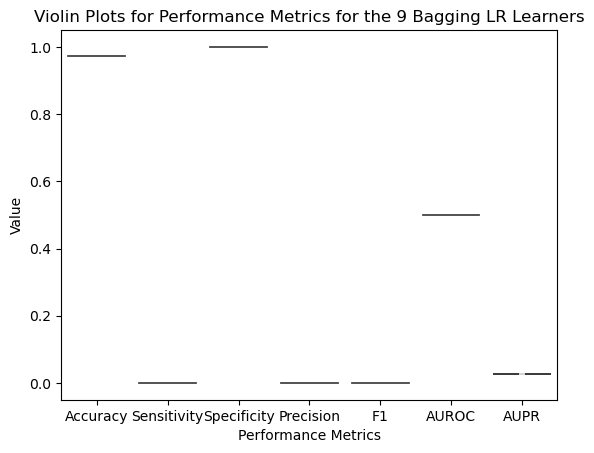

In [344]:
#violin plots from metrics except for Sl

import seaborn as sns
import matplotlib.pyplot as plt

sns.violinplot(data=metrics.iloc[:, 1:], gridsize=300)
plt.xlabel('Performance Metrics')
plt.ylabel('Value')
plt.title('Violin Plots for Performance Metrics for the 9 Bagging LR Learners')
plt.show()


In [345]:
metrics.describe()

,Sl,Accuracy,Sensitivity,Specificity,Precision,F1,AUROC,AUPR
count,9.000000,9.000000e+00,9.0,9.0,9.0,9.0,9.0,9.000000
mean,5.000000,9.731380e-01,0.0,1.0,0.0,0.0,0.5,0.026862
std,2.738613,1.177569e-16,0.0,0.0,0.0,0.0,0.0,0.000000
min,1.000000,9.731380e-01,0.0,1.0,0.0,0.0,0.5,0.026862
25%,3.000000,9.731380e-01,0.0,1.0,0.0,0.0,0.5,0.026862
50%,5.000000,9.731380e-01,0.0,1.0,0.0,0.0,0.5,0.026862
75%,7.000000,9.731380e-01,0.0,1.0,0.0,0.0,0.5,0.026862
max,9.000000,9.731380e-01,0.0,1.0,0.0,0.0,0.5,0.026862
